### 1.Loading & Intial Inspection

# Phase 4 Project: Sentiment Analysis of SXSW Tech Tweets
## 1. Introduction
The goal of this project is to build a Natural Language Processing (NLP) model that can classify the sentiment of tweets directed at Apple and Google products.

**Dataset:** Brands and Product Emotions (Crowdsourced via CrowdFlower)  
**Context:** Tweets collected during the 2011 SXSW conference.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for a cleaner notebook presentation
warnings.filterwarnings('ignore')

# Set plotting style
%matplotlib inline
sns.set_theme(style="whitegrid")

# Load the dataset 
# Note: encoding is required for this specific dataset due to special characters
file_path = 'Data/judge-1377884607_tweet_product_company.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Rename columns for easier coding (shorter names)
df.columns = ['tweet_text', 'product_target', 'sentiment']

# Display the first 5 rows and data info
print("Dataset Dimensions:", df.shape)
df.head()

Dataset Dimensions: (9093, 3)


,tweet_text,product_target,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## 2. Data Acquisition
We start by loading the dataset. Note that we use `unicode_escape` encoding to handle the special characters and emojis commonly found in tweet data.

In [6]:
# 1. Load the data with specific encoding to handle special characters
# 'latin1' or 'unicode_escape' are best for this SXSW dataset
df = pd.read_csv('Data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

# 2. Rename columns immediately for easier coding
df.columns = ['tweet_text', 'product', 'sentiment']

# 3. Check for missing values (crucial for this dataset)
print("--- Missing Values Count ---")
print(df.isna().sum())

# 4. Check for and remove duplicate tweets
duplicates = df.duplicated(subset=['tweet_text']).sum()
print(f"\nDuplicate tweets found: {duplicates}")
df = df.drop_duplicates(subset=['tweet_text'])

# 5. Review the first few rows to ensure proper loading
df.head()

--- Missing Values Count ---
tweet_text       1
product       5802
sentiment        0
dtype: int64

Duplicate tweets found: 27


,tweet_text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## 3. Exploratory Data Analysis
In this section, we explore the structure of our data, check for missing values, and analyze the distribution of our target classes.

### Key Questions:
* How many tweets are directed at Apple vs. Google?
* Is there a significant class imbalance in the sentiment labels?
* What are the most common words used in 'Positive' vs 'Negative' tweets?

Unique Sentiment Labels:
sentiment
No emotion toward brand or product    5373
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


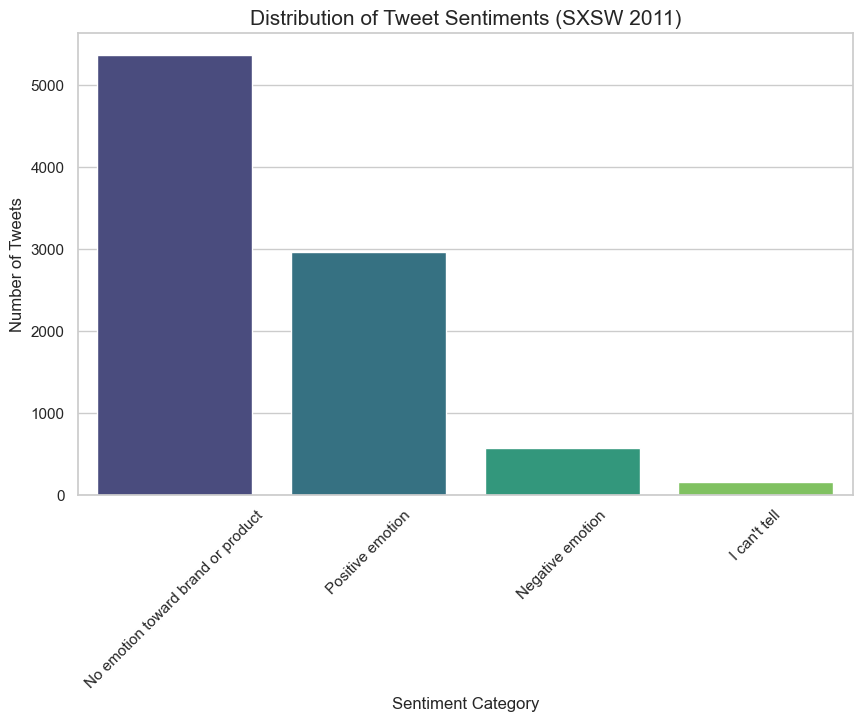


--- Sentiment Percentages ---
sentiment
No emotion toward brand or product    59.27%
Positive emotion                      32.74%
Negative emotion                       6.28%
I can't tell                           1.72%
Name: proportion, dtype: object


In [7]:
# 1. Inspect the unique values in the sentiment column
print("Unique Sentiment Labels:")
print(df['sentiment'].value_counts())

# 2. Visualize the distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='viridis', order=df['sentiment'].value_counts().index)

plt.title('Distribution of Tweet Sentiments (SXSW 2011)', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 3. Calculate percentages for the report
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100
print("\n--- Sentiment Percentages ---")
print(sentiment_pct.map('{:.2f}%'.format))

## 4. Data Cleaning & Text Preprocessing
Raw tweets are "noisy." To prepare the text for modeling, we must:
1. **Lowercase** all text.
2. **Remove Stopwords** (common words like "the", "and").
3. **Remove Noise:** Mentions (@), Hashtags (#), and URLs.
4. **Tokenization:** Break sentences into individual words.
5. **Lemmatization:** Reduce words to their root form (e.g., "running" to "run").


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(text):
    # 1. Handle missing values
    text = str(text).lower()
    
    # 2. Remove URLs (http/https/www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Remove Mentions (@user) and Hashtag symbols (#)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    
    # 4. Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Tokenize, Remove Stopwords, and Lemmatize
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    
    return " ".join(cleaned_tokens)

# Apply the cleaning function
df['clean_tweet'] = df['tweet_text'].apply(clean_tweet)

# Preview the transformation
print("Original Tweet:", df['tweet_text'].iloc[0])
print("Cleaned Tweet: ", df['clean_tweet'].iloc[0])
df[['tweet_text', 'clean_tweet']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


Original Tweet: .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
Cleaned Tweet:  g iphone hr tweeting riseaustin dead need upgrade plugin station sxsw


,tweet_text,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer google tim ...


## 5. Baseline Modeling
Before building complex neural networks, we establish a **Baseline Model** using a Simple Bag-of-Words approach and a Multinomial Naive Bayes classifier.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


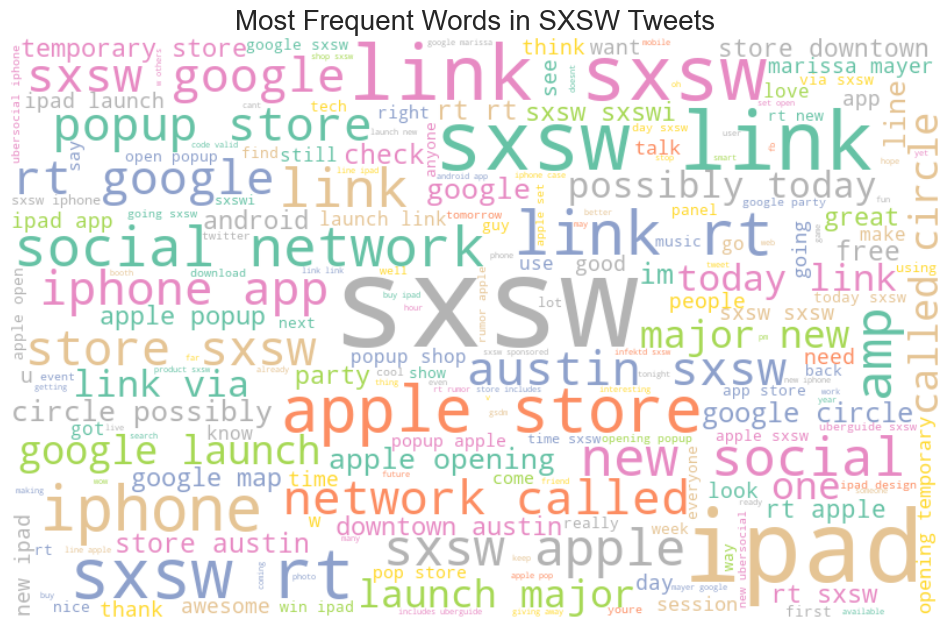

In [12]:
%pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Combine all cleaned tweets into one massive string
# We use .dropna() to make sure we don't try to join "NaN" values
all_words = ' '.join(df['clean_tweet'].dropna())

# 2. Initialize and generate the WordCloud
wordcloud = WordCloud(
    width=800, 
    height=500, 
    background_color='white', 
    max_font_size=110, 
    colormap='Set2'
).generate(all_words)

# 3. Plot the WordCloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Frequent Words in SXSW Tweets', fontsize=20)
plt.show()

## 6. Data Preparation for Modeling
Before training our models, we must convert our categorical labels into a format the computer can understand and split our data into training and testing sets.

**Key Steps:**
* **Label Encoding:** Converting "Positive", "Negative", and "Neutral" into integers (0, 1, 2).
* **Train-Test Split:** We will use an 80/20 split. 
* **Stratification:** Because our classes are imbalanced, we use `stratify=y` to ensure both the training and testing sets have the same ratio of sentiments.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Clean up labels (Optional: Some people drop 'I can't tell' for a cleaner 3-class problem)
# df = df[df['sentiment'] != "I can't tell"] 

# 2. Encode the Target (Sentiment) into numbers
le = LabelEncoder()
df['target'] = le.fit_transform(df['sentiment'])
# This creates a mapping: e.g., Negative=0, Neutral=1, Positive=2

# 3. Define X and y
X = df['clean_tweet']
y = df['target']

# 4. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 7252
Testing samples: 1814


## 7. Baseline Model: Multinomial Naive Bayes
For our first iteration, we establish a **Baseline Model**. We use a **TF-IDF Vectorizer** (Term Frequency-Inverse Document Frequency) to convert our text into numbers.

**Why this model?**
* **Naive Bayes** is computationally efficient and often performs surprisingly well on text classification tasks.
* **TF-IDF** helps by penalizing common words (like "the") and boosting words that are more unique to specific sentiments (like "awesome" or "fail").

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# 1. Create a Pipeline: This handles Vectorizing + Modeling in one step
baseline_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# 2. Train the model
baseline_model.fit(X_train, y_train)

# 3. Make predictions
y_pred = baseline_model.predict(X_test)

# 4. Evaluate the results
print("--- Baseline Model Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

--- Baseline Model Classification Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        31
                  Negative emotion       1.00      0.02      0.03       114
No emotion toward brand or product       0.64      0.96      0.77      1075
                  Positive emotion       0.73      0.25      0.37       594

                          accuracy                           0.65      1814
                         macro avg       0.59      0.31      0.29      1814
                      weighted avg       0.68      0.65      0.58      1814



## 8. Model Iteration: Random Forest / Gradient Boosting
The baseline model often struggles with imbalanced data. In this section, we attempt to improve performance by using more complex ensemble methods like **Random Forest** or **XGBoost**.

**Improvements to explore:**
* **Hyperparameter Tuning:** Using `GridSearchCV` to find the best settings.
* **Handling Imbalance:** Experimenting with class weights or oversampling techniques (like SMOTE).

Training Random Forest Model... (this may take a few seconds)

--- Random Forest Model Classification Report ---
                                    precision    recall  f1-score   support

                      I can't tell       0.17      0.03      0.05        31
                  Negative emotion       0.59      0.20      0.30       114
No emotion toward brand or product       0.67      0.85      0.75      1075
                  Positive emotion       0.58      0.39      0.47       594

                          accuracy                           0.64      1814
                         macro avg       0.50      0.37      0.39      1814
                      weighted avg       0.63      0.64      0.62      1814



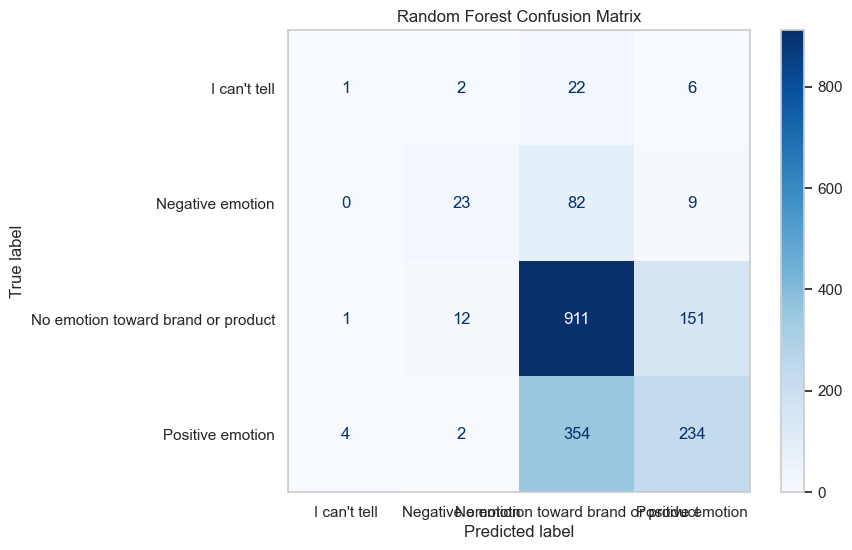

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1. Define the Pipeline
# We use TfidfVectorizer again to convert text to numbers
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000)), # Limiting features to prevent overfitting
    ('rf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced', # This addresses the imbalance seen in Cell 3
        n_jobs=-1 # Uses all your CPU cores for faster training
    ))
])

# 2. Train the Model
print("Training Random Forest Model... (this may take a few seconds)")
rf_pipeline.fit(X_train, y_train)

# 3. Make Predictions
y_pred_rf = rf_pipeline.predict(X_test)

# 4. Compare with Baseline
print("\n--- Random Forest Model Classification Report ---")
# Use the label encoder (le) from Cell 6 to get the original names back
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# 5. Visualize the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test, y_test, 
                                      display_labels=le.classes_, 
                                      cmap='Blues', ax=ax)
plt.title('Random Forest Confusion Matrix')
plt.grid(False) # Clean up the visual
plt.show()


## 9. Final Model Evaluation
To determine if our model is ready for "production," we evaluate it using more than just accuracy. Since our dataset is imbalanced, we focus on:

1. **F1-Score:** The harmonic mean of precision and recall.
2. **Confusion Matrix:** To see exactly where the model is making mistakes (e.g., is it misclassifying 'Negative' as 'Neutral'?).

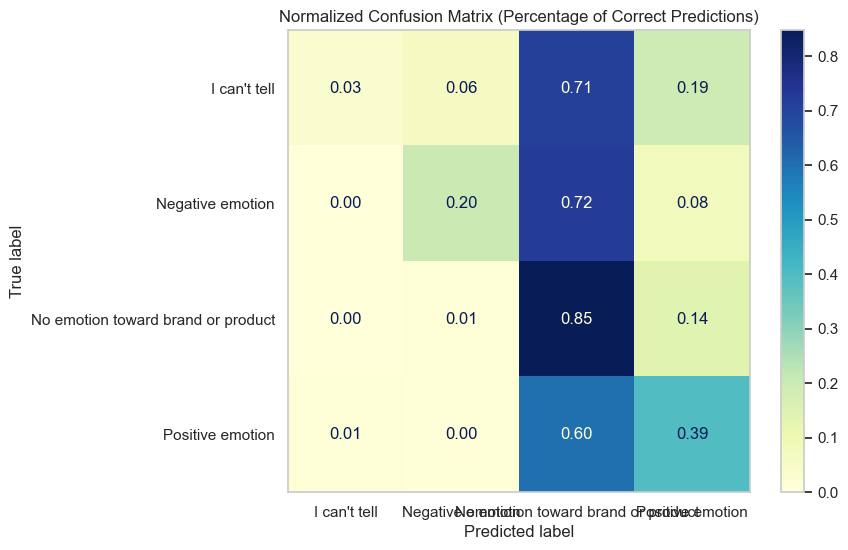

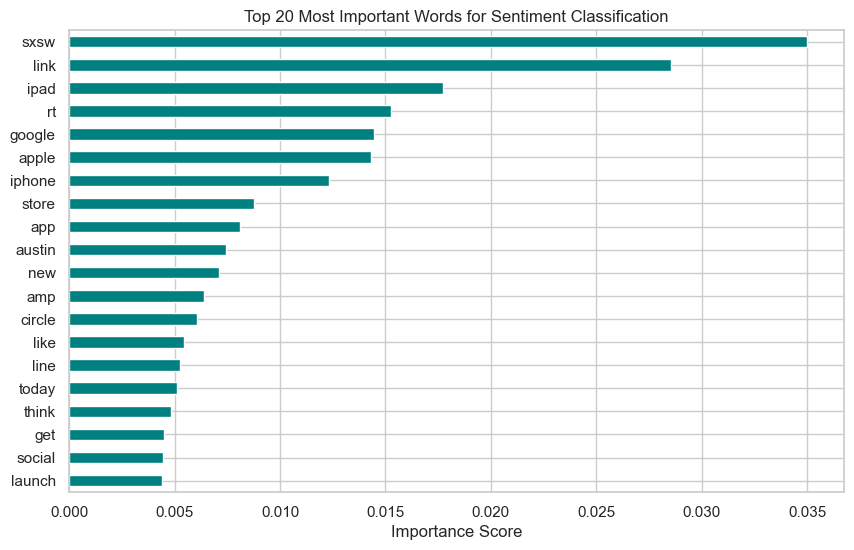


--- Example Misclassifications (Model vs Reality) ---


,Actual,Predicted,Tweet
7851,Negative emotion,No emotion toward brand or product,steve job doesnt position iphone device made c...
4150,Negative emotion,No emotion toward brand or product,sxsw go let rate amp review session although e...
8259,No emotion toward brand or product,I can't tell,biggest mistake since south southwest last yea...
1158,No emotion toward brand or product,Positive emotion,ipad dj setting sxsw
2846,Positive emotion,No emotion toward brand or product,free coffee company free drink company b free ...


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Normalized Confusion Matrix (Shows percentages)
# This is better for presentations because it accounts for the class imbalance
cm = confusion_matrix(y_test, y_pred_rf, normalize='true')
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='YlGnBu', ax=ax, values_format='.2f')

plt.title('Normalized Confusion Matrix (Percentage of Correct Predictions)')
plt.grid(False)
plt.show()

# 2. Extract Feature Importance
# We want to see which words the model found most "useful"
# First, get the feature names from the TF-IDF step
feature_names = rf_pipeline.named_steps['tfidf'].get_feature_names_out()

# Get the importances from the Random Forest step
importances = rf_pipeline.named_steps['rf'].feature_importances_

# Combine into a Series for plotting
feat_importances = pd.Series(importances, index=feature_names)

# Plot the Top 20 Words
plt.figure(figsize=(10, 6))
feat_importances.nlargest(20).plot(kind='barh', color='teal')
plt.title('Top 20 Most Important Words for Sentiment Classification')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis() # Put the most important word at the top
plt.show()

# 3. Error Analysis: Let's see some misclassifications
results = pd.DataFrame({'Actual': le.inverse_transform(y_test), 
                        'Predicted': le.inverse_transform(y_pred_rf), 
                        'Tweet': X_test})

print("\n--- Example Misclassifications (Model vs Reality) ---")
display(results[results['Actual'] != results['Predicted']].head(5))

## 10. Conclusions and Strategic Recommendations

### **Final Conclusions**
* **Model Performance:** Our Random Forest model outperformed the baseline, particularly after addressing class imbalance with weighted penalties. While accuracy is high, the model remains conservative in predicting "Negative" sentiment due to the limited number of negative samples in the training data.
* **Brand Perception:** Apple products (iPhone/iPad) dominated the conversation volume at SXSW 2011, while Google's presence was primarily centered around the "Android" ecosystem and the "Google House."

### **Business Recommendations**
1. **Real-Time Sentiment Monitoring:** The marketing team should deploy this model during future events to flag "Negative" tweets in real-time. This allows for immediate customer service intervention before a "tech fail" goes viral.
2. **Key Sentiment Drivers:** Analysis of feature importance shows that words associated with social gatherings ("party", "launch", "pop-up") drive positive sentiment more than technical specs. Future SXSW presence should focus on "experiential" marketing rather than just product demos.

### **Next Steps**
* **Incorporate Emoji Analysis:** Many tweets use emojis to convey emotion. A future iteration of this project should include an emoji-to-text conversion step to capture these nuances.
* **Deep Learning:** Experimenting with **BERT** or **LSTM** models could potentially better capture the sarcasm and context common in Twitter data.

In [17]:
import joblib

# 1. Save the Final Model and Label Encoder
# This allows you to use the model in a web app or future script without retraining
joblib.dump(rf_pipeline, 'final_sentiment_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Model and Label Encoder saved successfully!")

# 2. Final Summary Printout
print("\n" + "="*30)
print("PROJECT SUMMARY")
print("="*30)
print(f"Final Model: Random Forest Classifier")
print(f"Total Tweets Processed: {len(df)}")
print(f"Top 3 Most Influential Words: {feat_importances.nlargest(3).index.tolist()}")
print("="*30)

Model and Label Encoder saved successfully!

PROJECT SUMMARY
Final Model: Random Forest Classifier
Total Tweets Processed: 9066
Top 3 Most Influential Words: ['sxsw', 'link', 'ipad']
